In [5]:
!pip install -r /root/workspace/pytorch-pipeline-1/requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
!python3 /root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py

/opt/conda/lib/python3.7/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")
Traceback (most recent call last):
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 43, in <module>
    main()
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 40, in main
    test_audio_preprocess_dataset_stft()
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 18, in test_audio_preprocess_dataset_stft
    dataset = new_datasets.Audio_preprocess_dataset(config, annotation_df, audio_loader, 'cpu')
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/new_datasets.py", line 87, in __init__
    self.annotations = annotation_loader_with_indexes(config['annotations_dir'])
KeyError: 'annotations_dir'


In [77]:
!python3 /root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/new_datasets.py /root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/preprocessing-config.yml

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [34]:
!python3 /root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py

Traceback (most recent call last):
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 43, in <module>
    main()
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 40, in main
    test_audio_preprocess_dataset_stft()
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/test-processing.py", line 18, in test_audio_preprocess_dataset_stft
    dataset = new_datasets.Audio_preprocess_dataset(config, annotation_df, audio_loader, 'cpu')
  File "/root/workspace/pytorch-pipeline-1/data_preprocessing_gpu/new_datasets.py", line 87, in __init__
    self.annotations = annotation_loader_with_indexes(config['annotations_dir'])
KeyError: 'annotations_dir'


### Test STFT

In [76]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

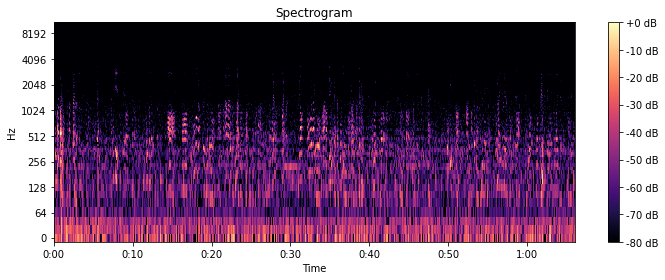

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import os 
import torchaudio

tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(S[0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

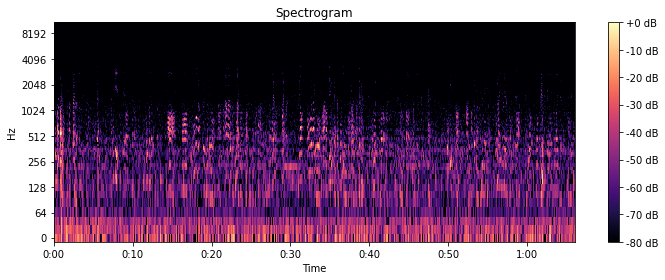

In [3]:

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# torch_tensor = torch.from_numpy(audio)

# Compute the spectrogram
S2 = torchaudio.transforms.Spectrogram(n_fft = 1024, hop_length = 512, window_fn=torch.hann_window)(audio)
S2 = S2.cpu().numpy()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(S2[0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [4]:
np.linalg.norm(S2-S)

0.0

### Test Power Spectrogram

In [51]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [52]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'PowerSpectrogram','n_fft': 1024,'hop_length': 512,'window': 'hann'}]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [78]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [79]:
S.shape

(4, 513, 469)

In [58]:
audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# torch_tensor = torch.from_numpy(audio)

# Compute the spectrogram
S2 = torchaudio.transforms.Spectrogram(n_fft = 1024, hop_length = 512, window_fn=torch.hann_window,power=2)(audio)
S2 = S2.cpu().numpy()

In [59]:
np.linalg.norm(S-S2)

0.0

In [82]:
import pandas as pd

def load_annotations_with_indexes(annotation_dir) :
    """
    Function that loads annotations files supposed to be in CSV format in a given directory. 
    This also associates indexes with each file to be consistent with the torch.utils.Dataset parent class. 
    The loaded annotation for each file are stored in a dictionnary.
    """
    index = 0
    annotations = {}
    for file in os.listdir(annotation_dir) :
        annotations['{}'.format(file.split('.csv')[-2])+'_idx_{}'.format(str(index))] = torch.tensor(pd.read_csv(os.path.join(annotation_dir,file)).values)
        index += 1
    return annotations

In [83]:
annotation_dir = '/root/workspace/dataset_2022/metadata_dev/dev-test-sony'

annotations = load_annotations_with_indexes(annotation_dir)

In [108]:
azi_rad = annotations['fold4_room24_mix013_idx_0'][:,3]*np.pi/180
ele_rad = annotations['fold4_room24_mix013_idx_0'][:,4]*np.pi/180
tmp_label = torch.cos(ele_rad)
x = torch.cos(azi_rad)*tmp_label
y = torch.sin(azi_rad)*tmp_label
z = torch.sin(ele_rad)
out = torch.cat((annotations['fold4_room24_mix013_idx_0'][:,0:3],x[:,None],y[:,None],z[:,None]),dim=1)

In [111]:
x[0] = 5

In [113]:
x[0]

tensor(5.)

In [106]:
print(annotations['fold4_room24_mix013_idx_0'][:,0:3].shape)
print(x[:,None].shape)
print(y[:,None].shape)
print(z[:,None].shape)

torch.Size([1791, 3])
torch.Size([1791, 1])
torch.Size([1791, 1])
torch.Size([1791, 1])


In [102]:
annotations['fold4_room24_mix013_idx_0'][:,0:3].shape

torch.Size([1791, 3])

In [103]:
x.shape

torch.Size([1791])

In [89]:
def convert_output_format_polar_to_cartesian(in_dict):
    out_dict = {}
    for frame_cnt in in_dict.keys():
        if frame_cnt not in out_dict:
            
            
            
            
            
            
            
            out_dict[frame_cnt] = []
            for tmp_val in in_dict[frame_cnt]:

                ele_rad = tmp_val[3]*np.pi/180.
                azi_rad = tmp_val[2]*np.pi/180

                tmp_label = np.cos(ele_rad)
                x = np.cos(azi_rad) * tmp_label
                y = np.sin(azi_rad) * tmp_label
                z = np.sin(ele_rad)
                out_dict[frame_cnt].append([tmp_val[0], tmp_val[1], x, y, z])
    return out_dict

In [90]:
out = convert_output_format_polar_to_cartesian(annotations)

In [91]:
out

{'fold4_room24_mix013_idx_0': [[tensor(1),
   tensor(5),
   tensor(-0.4067),
   tensor(-0.),
   tensor(-0.9135)],
  [tensor(1), tensor(0), tensor(-0.6427), tensor(-0.0112), tensor(0.7660)],
  [tensor(2), tensor(8), tensor(0.6428), tensor(0.), tensor(0.7660)],
  [tensor(2), tensor(0), tensor(-0.6292), tensor(-0.0110), tensor(0.7771)],
  [tensor(2), tensor(5), tensor(-0.4067), tensor(-0.), tensor(-0.9135)],
  [tensor(3), tensor(5), tensor(-0.4067), tensor(-0.), tensor(-0.9135)],
  [tensor(3), tensor(8), tensor(0.6428), tensor(0.), tensor(0.7660)],
  [tensor(3), tensor(0), tensor(-0.6427), tensor(-0.0112), tensor(0.7660)],
  [tensor(4), tensor(5), tensor(-0.4067), tensor(-0.), tensor(-0.9135)],
  [tensor(4), tensor(0), tensor(-0.6427), tensor(-0.0112), tensor(0.7660)],
  [tensor(4), tensor(8), tensor(0.6428), tensor(0.), tensor(0.7660)],
  [tensor(5), tensor(8), tensor(0.6428), tensor(0.), tensor(0.7660)],
  [tensor(5), tensor(5), tensor(-0.4067), tensor(-0.), tensor(-0.9135)],
  [tensor(

In [87]:
A = annotations['fold4_room24_mix013_idx_0']
SED_label = np.zeros((config['data']['nb_label_frames'], config['data']['nb_unique_classes']))
x_label = np.zeros((config['data']['nb_label_frames'], config['data']['nb_unique_classes']))
y_label = np.zeros((config['data']['nb_label_frames'], config['data']['nb_unique_classes']))
z_label = np.zeros((config['data']['nb_label_frames'], config['data']['nb_unique_classes']))
B = convert_output_format_polar_to_cartesian(desc_file_polar)
for line in range(B.shape[0]) :
    SED_label[B[line,0],B[line,1]]=1
    x_label[B[line,0],B[line,1]]=B[line,2]
    y_label[B[line,0],B[line,1]]=B[line,3]
    z_label[B[line,0],B[line,1]]=B[line,4]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


### Test Mel Spectrogram

In [71]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [72]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'MelSpectrogram','n_mels':128,'n_fft': 1024,'hop_length': 512,'window': 'hann'}]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda


/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [73]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [74]:
audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# torch_tensor = torch.from_numpy(audio)

# Compute the spectrogram
S2 = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'], n_mels=config['transforms'][0]['n_mels'],n_fft=config['transforms'][0]['n_fft'], 
            hop_length=config['transforms'][0]['hop_length'],window_fn=torch.hann_window)(audio)
S2 = S2.cpu().numpy()

In [75]:
np.linalg.norm(S-S2)

ValueError: operands could not be broadcast together with shapes (4,128,7285) (4,128,2846) 

### Test Scaling

In [100]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [1]:
from torch.utils.data import Dataset
from new_datasets import *

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'Scale','mean': 0,'std': 1}]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=load_annotations_with_indexes, 
audio_loader=load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [2]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [3]:
audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# Compute the spectrogram
S2 = config['transforms'][0]['mean']+config['transforms'][0]['std']*(audio-audio.mean())/audio.std()
S2 = S2.cpu().numpy()

In [4]:
np.linalg.norm(S-S2)

0.0

### Test MFCC

In [1]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [4]:
from torch.utils.data import Dataset
import new_datasets
import torch

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'MFCC','n_mfcc': 7}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda


/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [9]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [6]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# Compute the spectrogram
S2 = torchaudio.transforms.MFCC(sample_rate=config['sample_rate'], n_mfcc=config['transforms'][0]['n_mfcc'])(audio)
S2 = S2.cpu().numpy()

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [10]:
import numpy as np

np.linalg.norm(S-S2)

0.0

### Test MinMax Scaler 

In [11]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [2]:
from torch.utils.data import Dataset
import new_datasets
import torch

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'MinMaxScaler','min': 0,'max' : 1}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [3]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [7]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# Compute the spectrogram
S2 = (audio-audio.min())/(audio.max()-audio.min())
S2 = S2.cpu().numpy()

In [8]:
import numpy as np

np.linalg.norm(S-S2)

0.0

### Test Amplitude to dB

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [12]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'AmplitudeToDB'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [13]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [15]:
import numpy as np

np.linalg.norm(S-S2)

0.0

### Test Time Stretch

In [5]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [1]:
from torch.utils.data import Dataset
import new_datasets
import torch

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'TimeStretch','fixed_rate':1.,'n_fft': 1024,'hop_length': 512,'window': 'hann'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [2]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [5]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 =  torchaudio.transforms.TimeStretch(fixed_rate=config['transforms'][0]['fixed_rate'])(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [6]:
import numpy as np

np.linalg.norm(S-S2)

ValueError: operands could not be broadcast together with shapes (4,513,2846) (4,1456800) 

### Test frequency masking

In [1]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [1]:
from torch.utils.data import Dataset
import new_datasets
import torch

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'FrequencyMasking','freq_mask_param':1,'n_fft': 1024,'hop_length': 512,'window': 'hann'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [2]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [4]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.Spectrogram(n_fft=config['transforms'][0]['n_fft'], hop_length=config['transforms'][0]['hop_length'],window_fn=torch.hann_window)(audio)
S2 = torchaudio.transforms.FrequencyMasking(freq_mask_param=config['transforms'][0]['freq_mask_param'])(S2)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [5]:
import numpy as np

np.linalg.norm(S-S2)

0.0

### Test Time masking

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [7]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 24000,
'transforms': [{'type': 'TimeMasking','time_mask_param':1,'n_fft': 1024,'hop_length': 512,'window': 'hann'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

Using device cuda
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [8]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [9]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.Spectrogram(n_fft=config['transforms'][0]['n_fft'], hop_length=config['transforms'][0]['hop_length'],window_fn=torch.hann_window)(audio)
S2 = torchaudio.transforms.TimeMasking(time_mask_param=config['transforms'][0]['time_mask_param'])(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

IndexError: tuple index out of range

In [ ]:
import numpy as np

np.linalg.norm(S-S2)

### Test SALSA

In [35]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

# S2 = torchaudio.transforms.AmplitudeToDB()(audio)
# Compute the decibel transform
signal = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512,window_fn=torch.hann_window)(audio)

In [36]:
magnitude_spectrogram1 = signal[0,:,:].reshape(-1,1) #The spectrogram corresponding to the first channel
magnitude_spectrogram2 = signal[1,:,:].reshape(-1,1) #The spectrogram corresponding to the second channel

In [39]:
signal[0,:,:].shape

torch.Size([513, 2846])

In [17]:
signal = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512)(tens)
magnitude_spectrogram1 = signal[0,:,:].reshape(-1,1) #The spectrogram corresponding to the first channel
magnitude_spectrogram2 = signal[1,:,:].reshape(-1,1) #The spectrogram corresponding to the second channel

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [ ]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'SALSA','n_fft':1024, 'hop_length':512, 'itd':True, 'icld':True}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

In [ ]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [ ]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.AmplitudeToDB()(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [ ]:
import numpy as np

np.linalg.norm(S-S2)

### Test SALSA-Lite

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [ ]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'SALSA_LITE','n_fft':1024, 'hop_length':512, 'itd':True, 'icld':True,'window':'hann'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

In [ ]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [ ]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.AmplitudeToDB()(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [ ]:
import numpy as np

np.linalg.norm(S-S2)

### Test GCC-PHAT

In [ ]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')
mel_signal = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'], n_mels=128,
                                                              n_fft=1024, hop_length=512)(audio)
epsilon = 1e-8
num_channels = mel_signal.shape[0]
signal = torch.clone(mel_signal)

for i in range(num_channels) :
    for j in range(i,num_channels) : 
        
        complex_spectrogram_i = mel_signal[i,:,:] #The spectrogram corresponding to the ith channel
        complex_spectrogram_j = mel_signal[j,:,:] #The spectrogram corresponding to the jth channel

        numerator = complex_spectrogram_i*torch.conj(complex_spectrogram_j)
        denominator = torch.abs(complex_spectrogram_i*torch.conj(complex_spectrogram_j))
        denominator += epsilon
        quotient = torch.div(numerator,denominator)
        gcc_phat = torch.fft.ifft(quotient, dim=1)
        
        signal = torch.cat((signal,gcc_phat[None,:]),dim=0) #TODOO : Check for the lagging question

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [ ]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'GCC-PHAT','n_fft':1024, 'hop_length':512, 'window':'hann'}]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

In [ ]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [ ]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.AmplitudeToDB()(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [ ]:
import numpy as np

np.linalg.norm(S-S2)

### Test PCEN

In [ ]:
!rm -R /root/workspace/dataset_2022/mic_dev/preprocessed_dir

In [ ]:
from torch.utils.data import Dataset
import new_datasets

config = {'annotations_dir': '/root/workspace/dataset_2022/metadata_dev/dev-test-sony',
'audio_dir': '/root/workspace/dataset_2022/mic_dev/dev-test-sony',
'preprocessed_data_dir' : '/root/workspace/dataset_2022/mic_dev/preprocessed_dir',
'sample_rate': 24000,'num_samples': 22050,
'transforms': [{'type': 'PCEN','n_fft':1024, 'hop_length':512, 'window':'hann','alpha':0.98,'delta':2,'r':0.5,'s':0.025,'epsilon':1e-8}]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# create the dataset
dataset = new_datasets.Audio_preprocess_dataset(config=config, annotation_loader_with_indexes=new_datasets.load_annotations_with_indexes, 
audio_loader=new_datasets.load_audio, device=device)

# # preprocess and save the audio data
batch_size = 1
num_workers = 0
save_as_tensor = True
dataset.preprocess_and_save(batch_size, num_workers, save_as_tensor)

In [ ]:
tens = torch.load('/root/workspace/dataset_2022/mic_dev/preprocessed_dir/processed_fold4_room23_mix001')

S = tens.cpu().numpy()

In [ ]:
import torchaudio

audio, sr = torchaudio.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')

S2 = torchaudio.transforms.AmplitudeToDB()(audio)
# Compute the decibel transform
S2 = S2.cpu().numpy()

In [ ]:
import numpy as np

np.linalg.norm(S-S2)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:633: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  normalized, onesided, return_complex)


ValueError: too many values to unpack (expected 2)

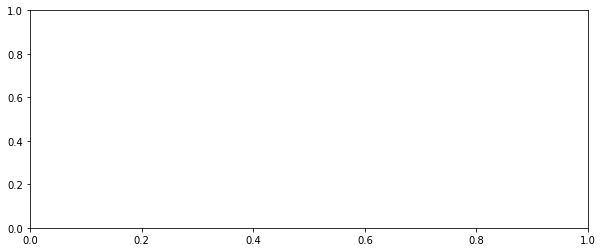

In [74]:
import matplotlib.pyplot as plt
import librosa.display
import torch

audio = librosa.load('/root/workspace/dataset_2022/mic_dev/dev-test-sony/fold4_room23_mix001.wav')[0]

torch_tensor = torch.from_numpy(audio)

# Compute the spectrogram
S2 = torch.stft(torch_tensor, n_fft = 1024, hop_length = 512)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(S2, ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [63]:
S-S2[:,:44]

array([[[ 2.0370870e+00+0.0000000e+00j,  2.5122869e-01+0.0000000e+00j,
          2.3931866e+00+0.0000000e+00j, ...,
         -2.2402477e+00+0.0000000e+00j, -8.1145060e-01+0.0000000e+00j,
          5.6639729e+00+0.0000000e+00j],
        [ 4.7482485e-01-3.8286483e-01j,  1.1315916e+00+1.7960161e-01j,
         -1.3891784e+00-8.6966038e-02j, ...,
          5.2584720e-01-1.0102069e+00j,  1.0543588e-01+3.1778646e+00j,
         -2.7168720e+00+5.9673476e-01j],
        [-9.8687619e-01+1.0376180e-01j, -1.4681230e+00-7.6562285e-01j,
          1.5768284e-01-9.6280795e-01j, ...,
          3.5628891e+00-1.0981359e+00j,  1.6876786e+00-1.2739069e+00j,
          1.4825076e+00-5.8014745e-01j],
        ...,
        [-1.4782557e-03-6.8270956e-06j, -2.7779636e-03+3.5978376e-04j,
          2.5239955e-03+8.0570149e-05j, ...,
          1.1723539e-03-2.3996960e-03j, -2.2878994e-03+1.7997553e-03j,
          2.5324307e-03+9.2782854e-04j],
        [-2.7716216e-03+3.4308050e-06j, -1.4546842e-03+1.8218989e-04j,
    

In [ ]:
/usr/bin/python3 -m pip install ipykernel -U --user --force-reinstall

: 